In [1]:
import pandas as pd
import pymongo
from pymongo import MongoClient

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']
metadata_coll = db.metadata

## Seleziono solo i film che hanno ricevuto almeno un tot numero di votazioni

In [2]:
num_votazioni = 250
movie_rates_df = pd.DataFrame(metadata_coll.find({},{'_id':'_id', 'vote_average':'vote_average','vote_count':'vote_count'}))
movie_rates_df = movie_rates_df.rename(columns={'_id':'movie_id'})
movie_rates_df = movie_rates_df.loc[movie_rates_df['vote_count'] >= num_votazioni]
movie_rates_df


,movie_id,vote_average,vote_count
0,862,7.7,5415.0
1,8844,6.9,2413.0
5,949,7.7,1886.0
9,710,6.6,1194.0
12,21032,7.1,423.0
...,...,...,...
44924,269795,5.5,277.0
44982,353491,5.7,688.0
45107,378236,5.8,327.0
45142,339692,6.9,324.0


In [3]:

#people_coll = db.people
#actors_df = pd.DataFrame(people_coll.find( {'jobs': { '$in': ["Actor"]} },{'_id':'_id', 'name':'name'}))
#actors_df


In [4]:
cast_coll = db.cast
cast_df = pd.DataFrame(cast_coll.find({},{'movie_id':'movie_id', 'person_id':'person_id'}))
cast_df.head()


,_id,person_id,movie_id
0,5f581138a447e657197d6da8,31.0,862.0
1,5f581138a447e657197d6da9,12898.0,862.0
2,5f581138a447e657197d6daa,7167.0,862.0
3,5f581138a447e657197d6dab,12899.0,862.0
4,5f581138a447e657197d6dac,12900.0,862.0


## Film e attori che vi hanno partecipato

In [5]:
movies_actor_df = pd.merge(cast_df,movie_rates_df, on='movie_id')
movies_actor_df = movies_actor_df.drop(columns=['_id','vote_count'])
tmp1 = movies_actor_df.groupby(['movie_id','person_id'])
tmp1.first()


vote_average
movie_id person_id              
5.0      62.0                6.5
         138.0               6.5
         2545.0              6.5
         2555.0              6.5
         3122.0              6.5
...                          ...
419430.0 1704626.0           7.2
         1754534.0           7.2
         1754535.0           7.2
         1754536.0           7.2
         1754537.0           7.2

[96047 rows x 1 columns]

## Filtro attori in base al numero di film a cui hanno partecipato  

In [6]:
num_film = 1
num_film_actor_df = movies_actor_df.groupby('person_id').count().reset_index()
num_film_actor_df = num_film_actor_df.rename(columns={'vote_average':'num_film'})
num_film_actor_df = num_film_actor_df.drop(columns='movie_id')
num_film_actor_df = num_film_actor_df.loc[num_film_actor_df['num_film'] >= num_film]
actors_id_num_film = num_film_actor_df['person_id']
actors_id_num_film.head()


0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: person_id, dtype: float64

## Attori e media dei film a cui hanno partecipato

In [7]:
tmp = movies_actor_df.loc[movies_actor_df['person_id'].isin(actors_id_num_film)] 
actors_mean_rate_films = tmp.groupby('person_id').mean().reset_index().drop(columns='movie_id').rename(columns=   {'vote_average':'vote_average_films'})

actors_mean_rate_films.head()

,person_id,vote_average_films
0,1.0,6.600000
1,2.0,7.414286
2,3.0,6.716129
3,4.0,6.864286
4,5.0,8.100000


In [8]:
tmp2 = pd.merge(movies_actor_df, actors_mean_rate_films, on='person_id')
tmp3 = tmp2.groupby('movie_id').mean().reset_index().rename(columns={'vote_average_films':'cast_vote_average'}).drop(columns='person_id')
tmp3.head(100)


,movie_id,vote_average,cast_vote_average
0,5.0,6.5,6.543554
1,11.0,8.1,7.880240
2,12.0,7.6,6.925247
3,13.0,8.2,7.715754
4,14.0,7.9,7.286435
...,...,...,...
95,177.0,7.2,6.949235
96,179.0,6.2,6.448375
97,180.0,7.1,6.651791
98,184.0,7.3,6.985190


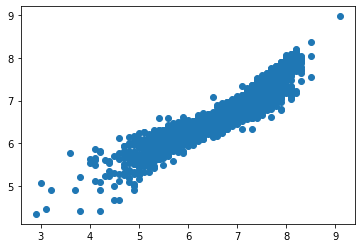

In [9]:
import matplotlib.pyplot as plt 
plt.scatter(tmp3.vote_average,tmp3.cast_vote_average)


# Sotto ipotesi 1: cambio metodo punteggio bravura attore
###    Dato un film seleziono solo i film a cui ha partecipato l'attore fino a quel momento

In [10]:
movie_rates_date_df = pd.DataFrame(metadata_coll.find({},{'_id':'_id', 'vote_average':'vote_average','vote_count':'vote_count','release_date':'release_date'}))
movie_rates_date_df = movie_rates_date_df.rename(columns={'_id':'movie_id'})
movie_rates_date_df = movie_rates_date_df.loc[movie_rates_date_df['vote_count'] >= 250]

movie_rates_date_df['release_date'] = pd.to_datetime(movie_rates_date_df['release_date'],
                                                     format="%Y/%m/%d")
movie_rates_date_df.head()

,movie_id,release_date,vote_average,vote_count
0,862,1995-10-30,7.7,5415.0
1,8844,1995-12-15,6.9,2413.0
5,949,1995-12-15,7.7,1886.0
9,710,1995-11-16,6.6,1194.0
12,21032,1995-12-22,7.1,423.0


In [11]:
from pprint import pprint
movies_actor_date_df = pd.merge(cast_df,movie_rates_date_df, on='movie_id').drop(columns='_id')
movie_id_date_actors_dict = movies_actor_date_df.groupby(['movie_id','release_date','vote_average'])['person_id'].apply(list).to_dict()
movies_actor_date_df.head()

,person_id,movie_id,release_date,vote_average,vote_count
0,31.0,862.0,1995-10-30,7.7,5415.0
1,12898.0,862.0,1995-10-30,7.7,5415.0
2,7167.0,862.0,1995-10-30,7.7,5415.0
3,12899.0,862.0,1995-10-30,7.7,5415.0
4,12900.0,862.0,1995-10-30,7.7,5415.0


In [12]:
import math

index = 0
formatted_dict_for_df = {}

for movie_id, date, rating  in movie_id_date_actors_dict:
    person_id_average_rate_before_actual_list = []
    for person_id in movie_id_date_actors_dict[(movie_id, date,rating)]:
        films_before_actual_df = movies_actor_date_df.loc[(movies_actor_date_df['person_id'] == person_id) & (movies_actor_date_df['release_date'] <  date) & (movies_actor_date_df['movie_id'] != movie_id)]
        mean_rating_film_before_actual = films_before_actual_df['vote_average'].mean()
        if math.isnan(mean_rating_film_before_actual):
            mean_rating_film_before_actual = 0
        person_id_average_rate_before_actual_list.append(mean_rating_film_before_actual)
    #movie_id_date_actors_dict[(movie_id, date,rating)] = pd.Series(person_id_average_rate_before_actual_list).mean()
    key_values = [movie_id,rating, pd.Series(person_id_average_rate_before_actual_list).mean() ]
    formatted_dict_for_df[index] = []


In [13]:
 # pprint(movie_id_date_actors_dict)
 index = 0
 formatted_dict_for_df = {}
 for movie_id, date, rating  in movie_id_date_actors_dict:
     key_values = [movie_id,rating, movie_id_date_actors_dict[(movie_id, date,rating)]]
     formatted_dict_for_df[index] = key_values
     index = index + 1
pprint(formatted_dict_for_df)


3566069347319],
 2960: [228150.0, 7.4, 4.824456088137009],
 2961: [228161.0, 6.8, 5.713030303030303],
 2962: [228165.0, 5.7, 3.3544426473186273],
 2963: [228194.0, 7.3, 1.6663247863247863],
 2964: [228205.0, 7.3, 3.576052631578947],
 2965: [228326.0, 7.3, 3.9116287843627022],
 2966: [228967.0, 6.1, 3.6126644736842097],
 2967: [228970.0, 7.0, 1.9206140350877192],
 2968: [229297.0, 6.5, 2.7560352908740007],
 2969: [230179.0, 5.3, 2.7183465309200603],
 2970: [231176.0, 6.6, 1.8133333333333335],
 2971: [231576.0, 6.4, 4.324897119341564],
 2972: [232572.0, 5.7, 3.008860171891025],
 2973: [232672.0, 6.6, 4.040261300825817],
 2974: [233063.0, 7.1, 1.9916666666666667],
 2975: [234200.0, 7.7, 4.1723125],
 2976: [236735.0, 7.1, 1.9355555555555555],
 2977: [237791.0, 8.1, 0.0],
 2978: [238215.0, 5.5, 4.842902721433401],
 2979: [238603.0, 5.7, 2.5439814814814814],
 2980: [238615.0, 6.3, 3.469760394644116],
 2981: [238636.0, 6.6, 3.4899999999999993],
 2982: [238713.0, 6.9, 3.0377942892843413],
 298

In [14]:
movies_rating_before_actual_df = pd.DataFrame.from_dict(formatted_dict_for_df, orient='index',  columns=['movie_id', 'vote_average', 'cast_rate_average_previous'])

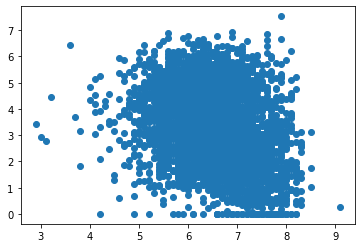

In [15]:
plt.scatter(movies_rating_before_actual_df.vote_average,movies_rating_before_actual_df.cast_rate_average_previous)
